<a href="https://colab.research.google.com/github/eeshahar/data-science/blob/main/EeshHariU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bike rental predictions**

**Context:** I really like to bike and I was interested in this dataset because it had a lot of attributes about the conditions at which people ride bicycles and maybe it could help me determine when next I will go on a bike ride

In [ ]:
import xarray as xr
!pip install bambi
import bambi as bmb
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [ ]:
!pip install -q "preliz[full,notebook]"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data:** https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

The goal of my project is to predict how many bikes are rented using the columns listed below.

In [5]:
bike = pd.read_csv('/content/drive/MyDrive/Data science/hour.csv')
print(bike.columns)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


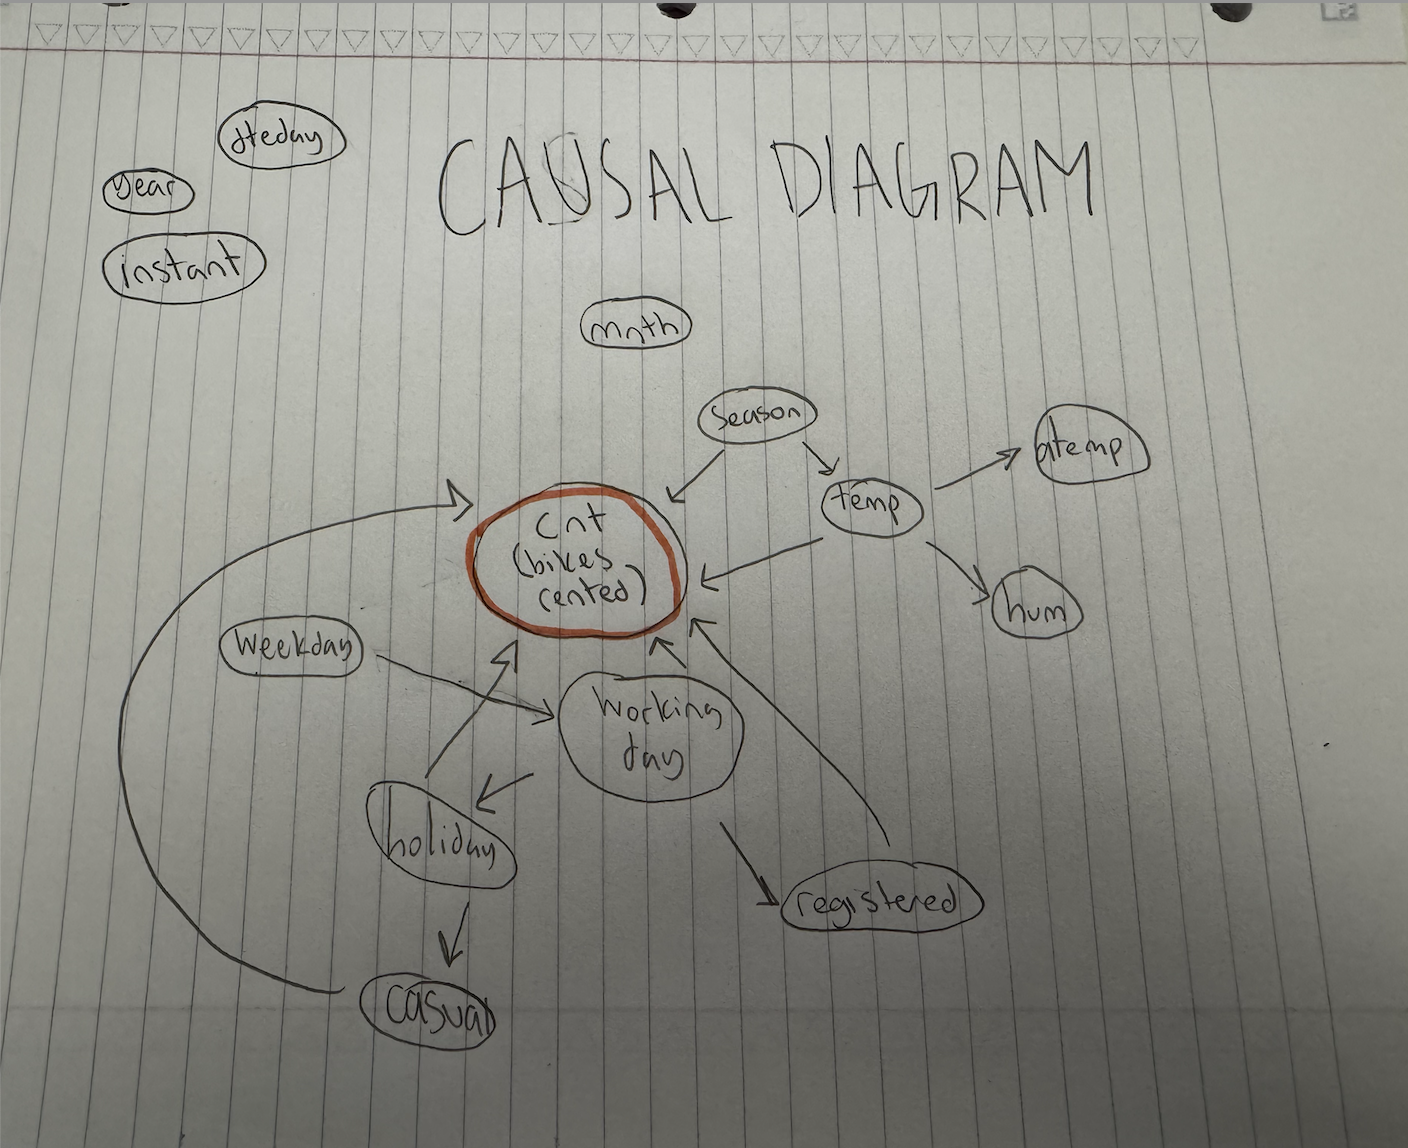

Notes on the causal diagram that I later realized:

1. temperature doesn't exactly impact humidity


In [6]:
bike.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

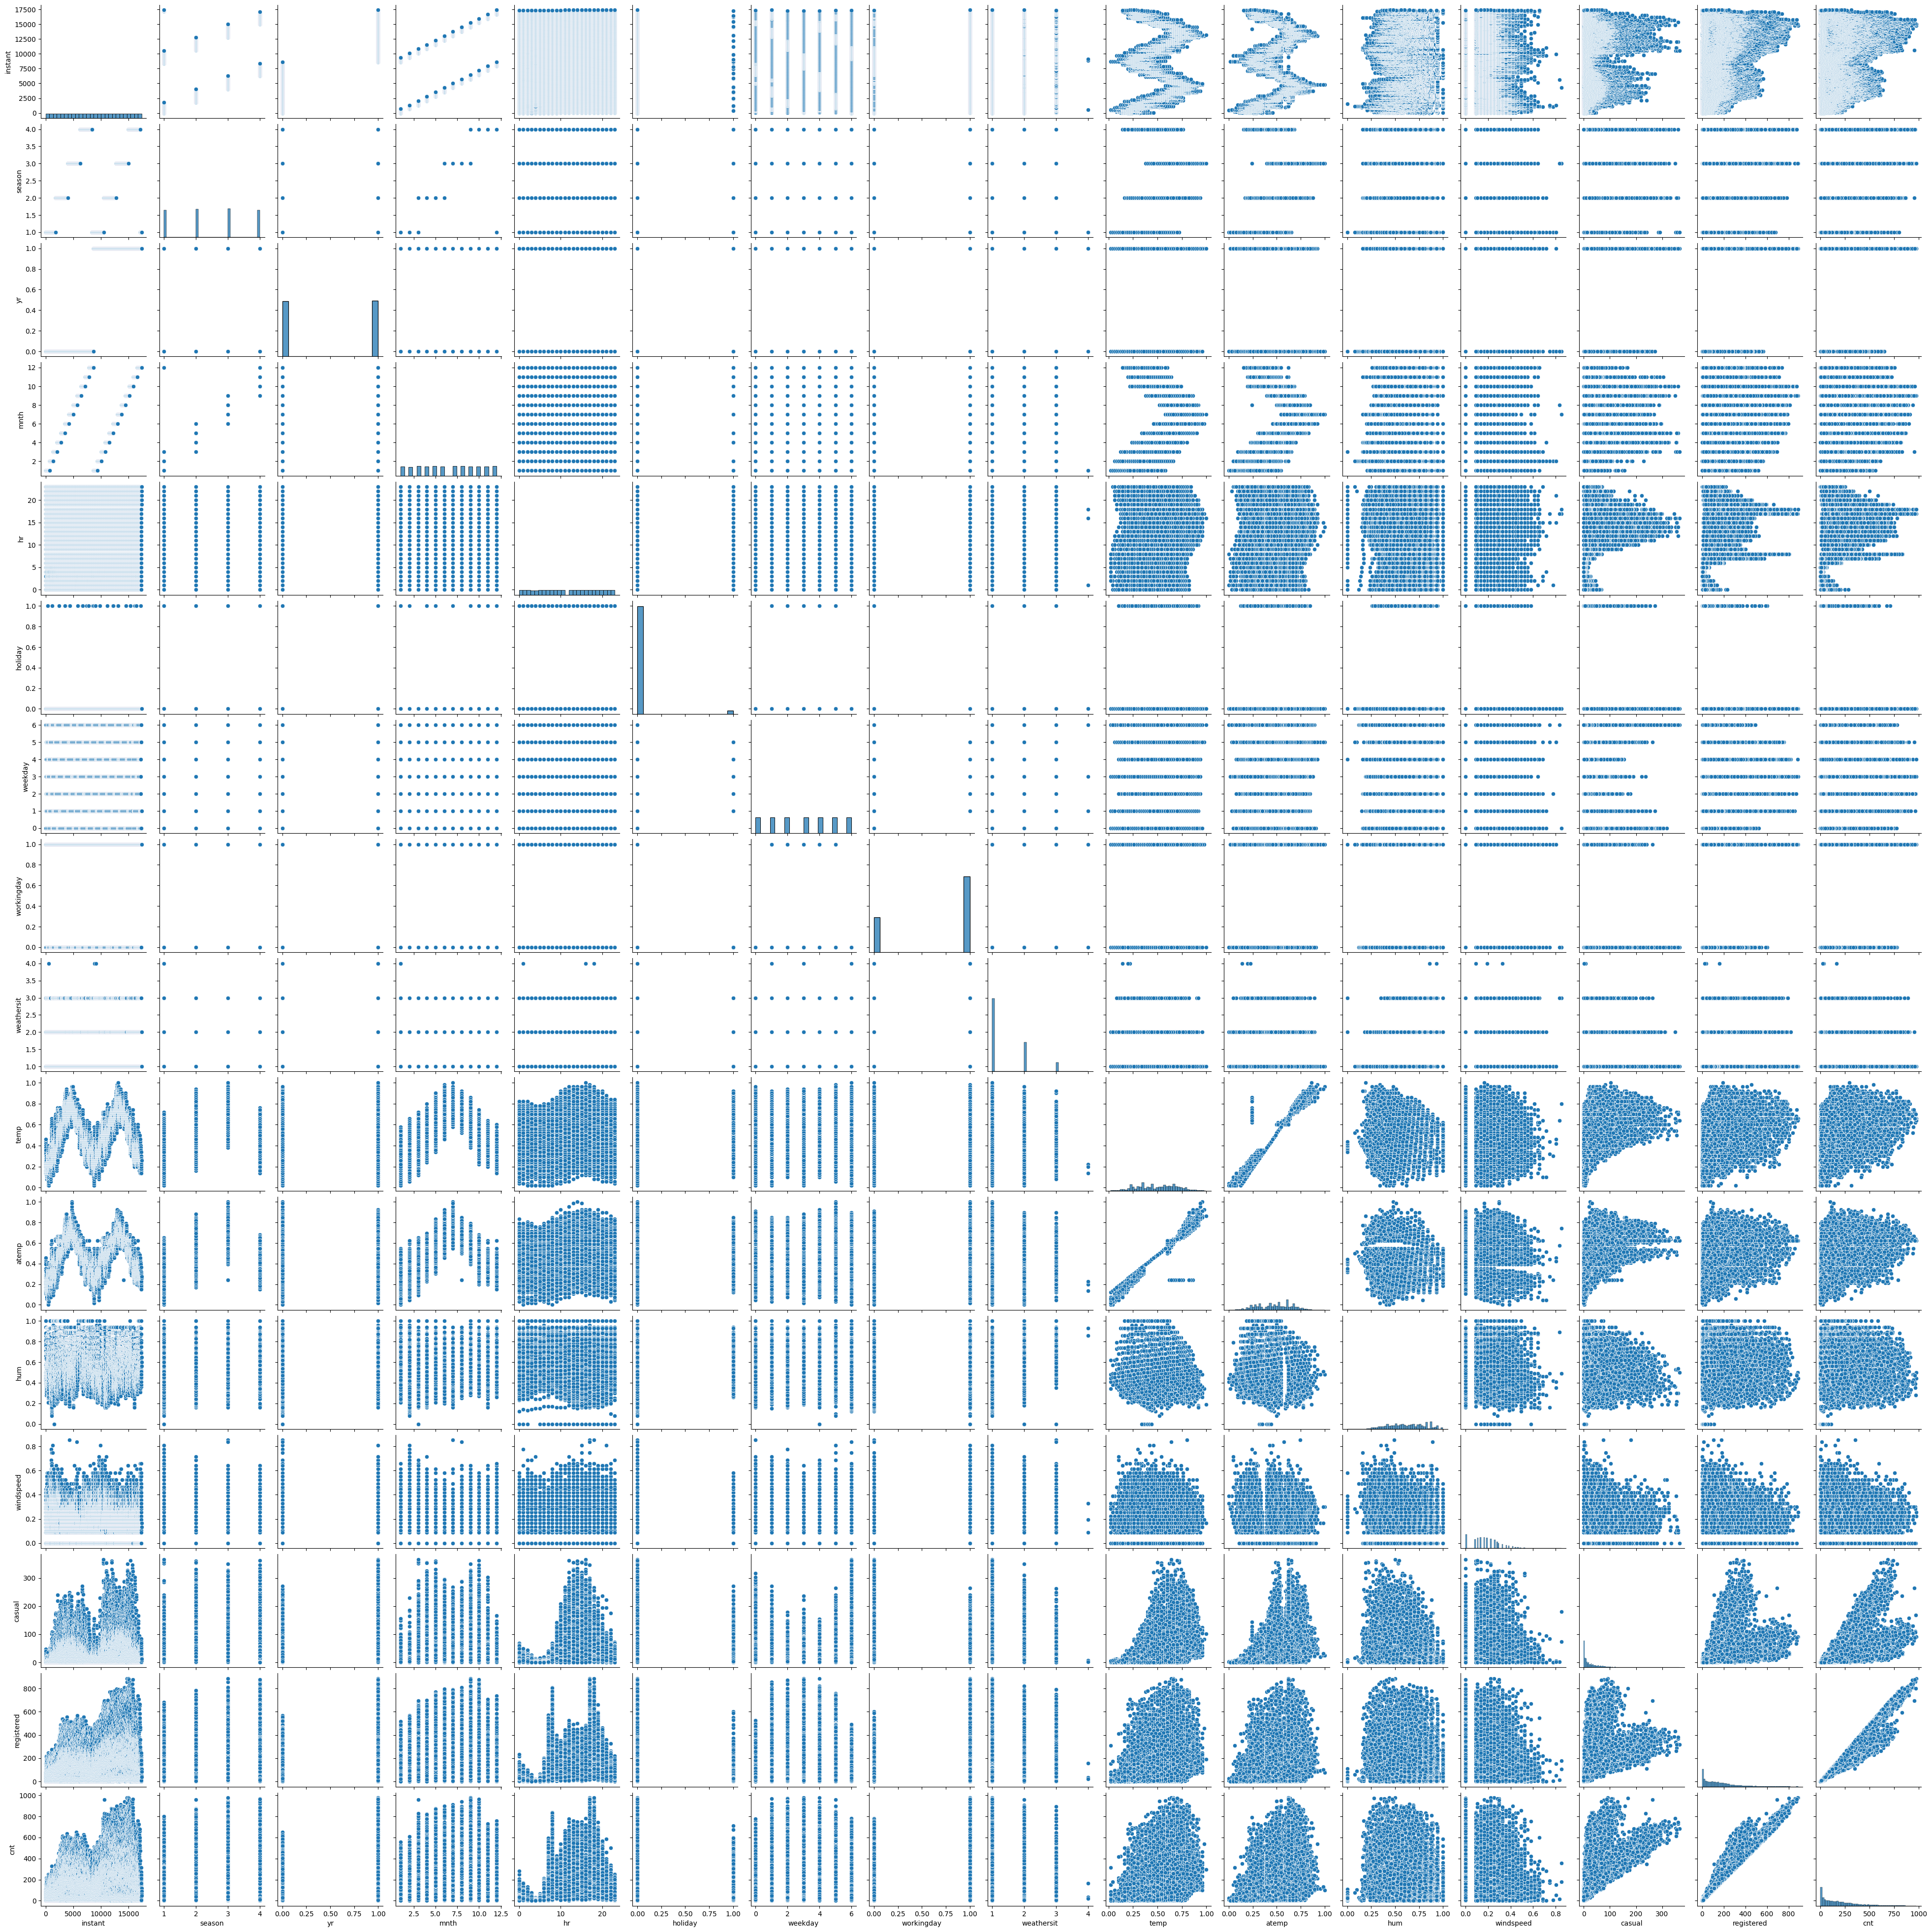

In [7]:
import seaborn as sns
sns.pairplot(bike)
plt.show()

**Models:** for this part I'm going to do a couple of models comparing the most strongly correlated variables to see which ones work best

In [ ]:
#for this model I included all the most essential variables. So all of them pretty much except instance, year, dteday (the date), atemp (same as temp), and registered/casual because I didn't see how those would be as useful
model_all = bmb.Model("cnt ~ season + mnth + holiday + weekday + workingday + weathersit + temp + hum + windspeed", bike, family="negativebinomial")
idata_all = model_all.fit(idata_kwargs={"log_likelihood":True})

(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='workingday', ylabel='cnt'>], dtype=object))

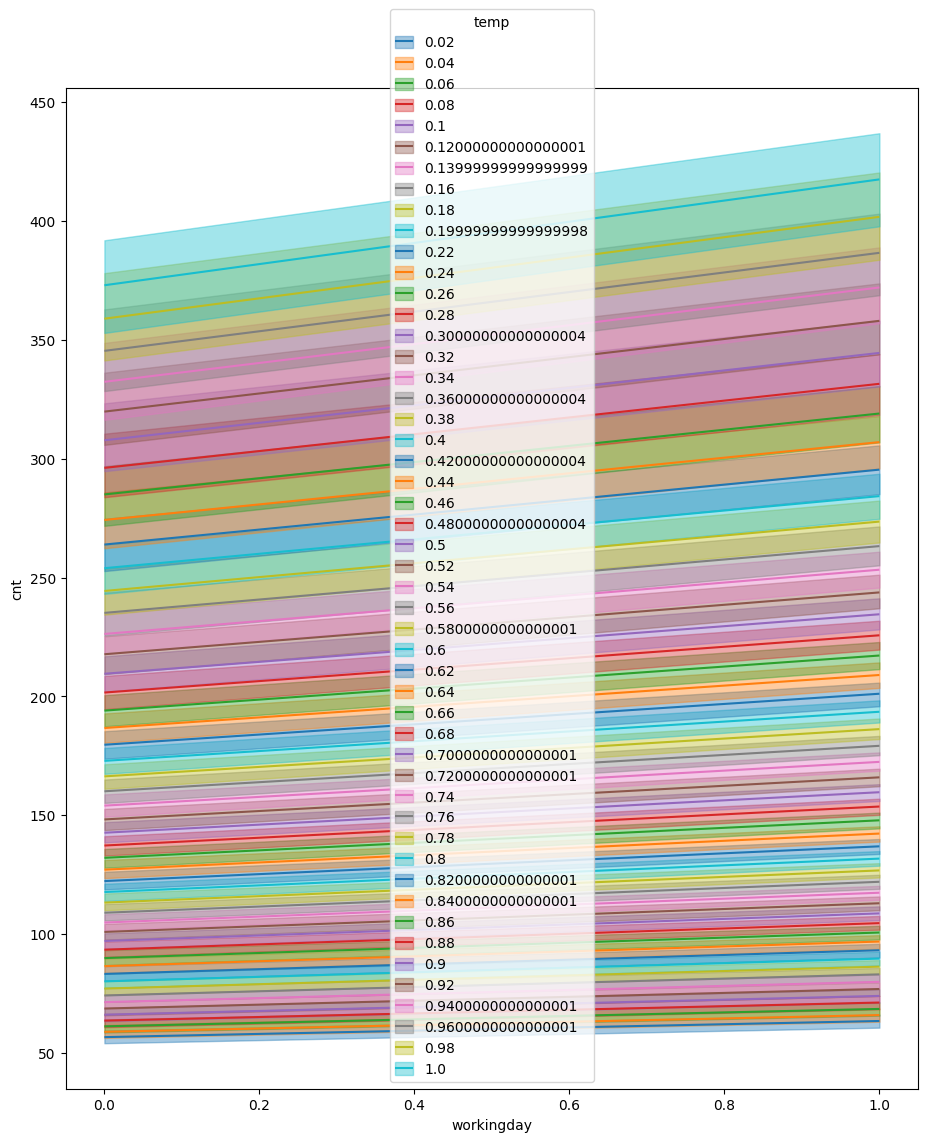

In [9]:
bmb.interpret.plot_predictions(model_all,
                               idata_all,
                               ["workingday","temp"],
                               fig_kwargs={"figsize":(11, 13)})#,
                               #legend=False)

The model above shows cnt based on workinday and temp. It's kind of messy because temp is continuous but the trend shows that higher temps lead to higher counts, regardless of whether or not its a working day. Also the lines spread out more on the right side of the graph and that's because workingday is a binary variable so its only inputs are 1 and 0. Basically people bike more when it's warm, and they do it even more on workdays than on weekends, which was unexpected.

(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='hum', ylabel='cnt'>], dtype=object))

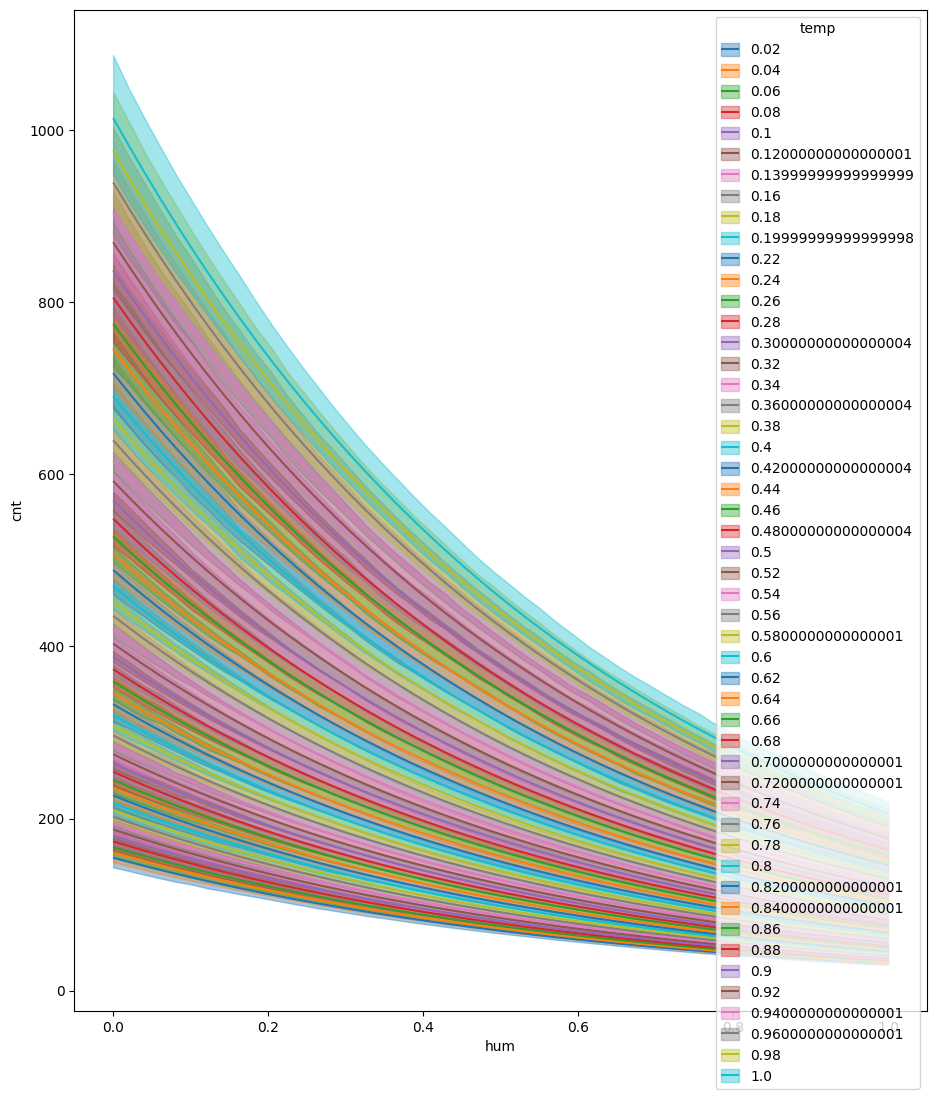

In [10]:
bmb.interpret.plot_predictions(model_all,
                               idata_all,
                               ["hum","temp"],
                               fig_kwargs={"figsize":(11, 13)})#,
                               #legend=False)

I think this model turned out a lot better than the one above, the x axis is humidity and the lines are at different temperatures. The relationship here is that as the humidity goes up, the count of bike rentals goes down. So when the humidity is low, temperature has a great effect on the bikes rented but as humidity goes up that has a much larger effect than temperature

In [ ]:

model_workimpact = bmb.Model("cnt ~ registered + weekday + holiday", bike, family="poisson")
idata_workimpact = model_workimpact.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_weather = bmb.Model("cnt ~ temp * hum + windspeed + weathersit", bike, family="negativebinomial")
idata_weather = model_weather.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_workimpact2 = bmb.Model("cnt ~ hr * workingday + holiday", bike, family="negativebinomial")
idata_workimpact2 = model_workimpact2.fit(idata_kwargs={"log_likelihood":True})

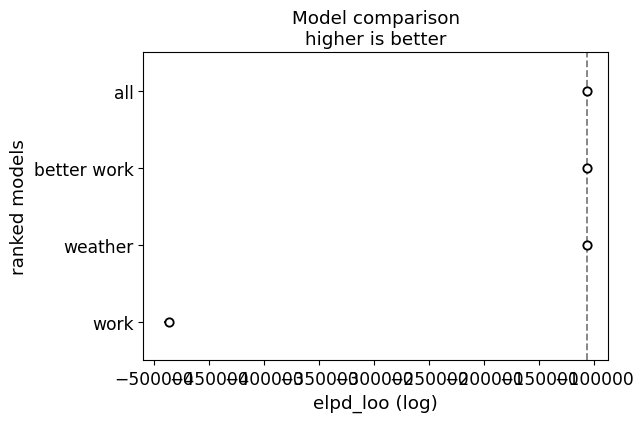

In [20]:
cmp = az.compare({
    "all": idata_all,
    "work": idata_workimpact,
    "weather": idata_weather,
    "better work": idata_workimpact2,
})
axes = az.plot_compare(cmp)

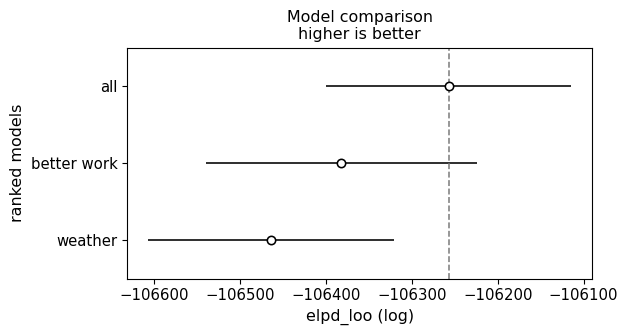

In [21]:
cmp = az.compare({
    "all": idata_all,
    "weather": idata_weather,
    "better work": idata_workimpact2,
})
axes = az.plot_compare(cmp)

(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='temp', ylabel='cnt'>], dtype=object))

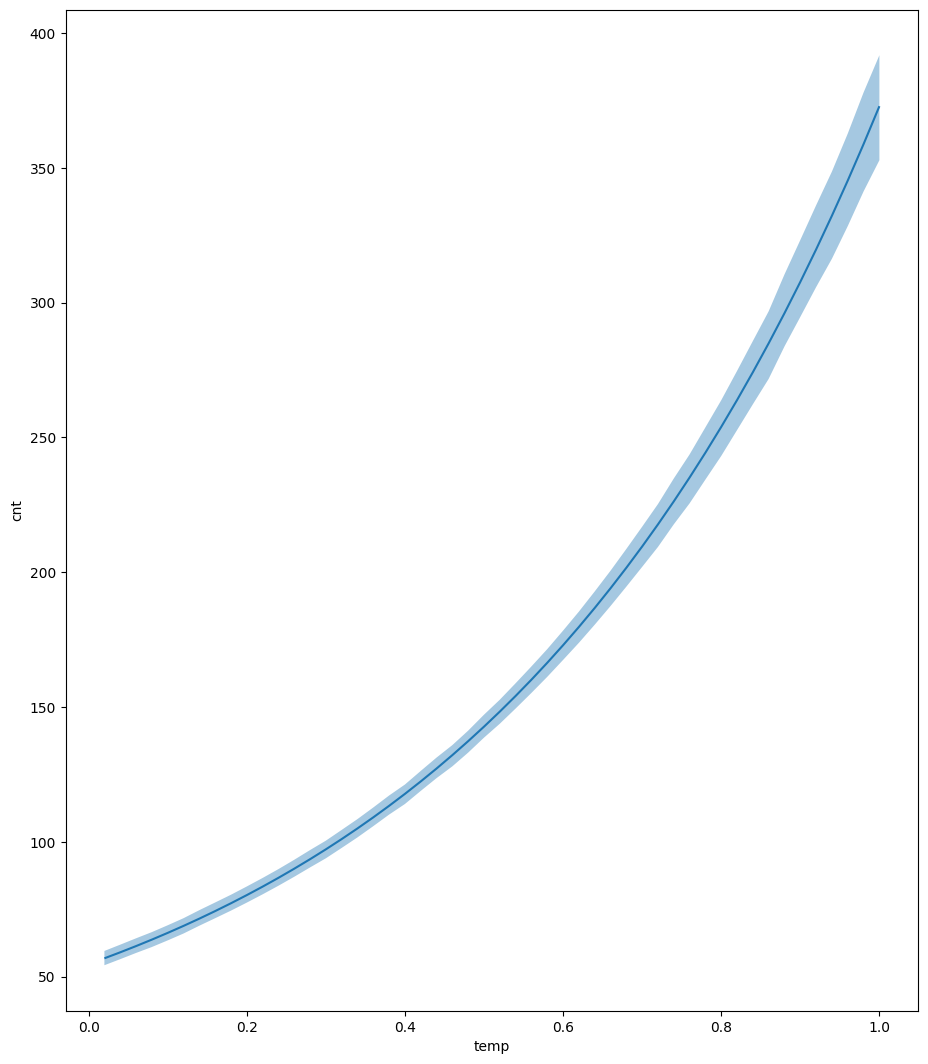

In [30]:
bmb.interpret.plot_predictions(
    model_all,
    idata_all,
    ["temp"],  # predictors to plot
    fig_kwargs={"figsize": (11, 13)}
)

(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='windspeed', ylabel='cnt'>], dtype=object))

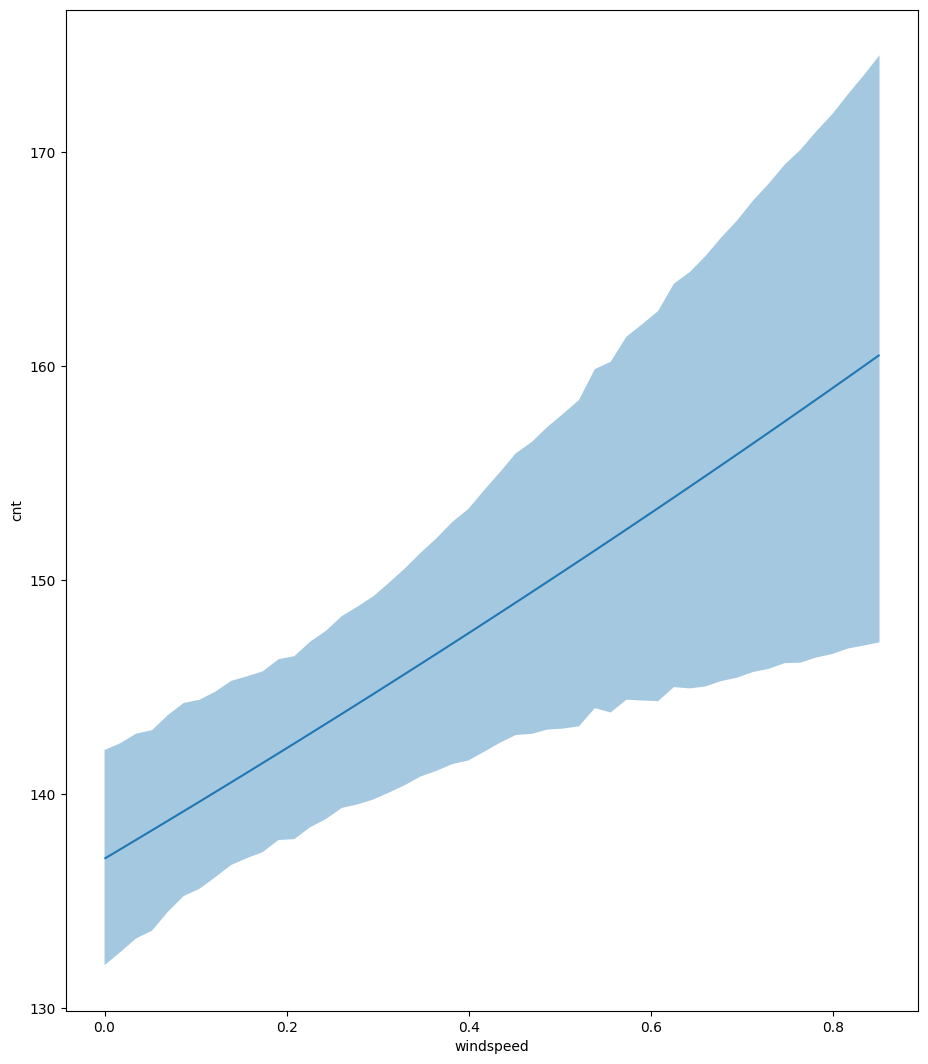

In [16]:
bmb.interpret.plot_predictions(
    model_all,
    idata_all,
    ["windspeed"],  # predictors to plot
    fig_kwargs={"figsize": (11, 13)}
)